In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
dataset_path = "/content/drive/MyDrive/Capstone/classified_images"
input_shape = (90, 120, 3)
classes = ['Fair_Light', 'Medium_Tan', 'Dark_Deep']
EPOCHS = 50  # Increase the number of epochs
BS = 32

In [ ]:
data = []
labels = []

In [ ]:
for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    print(class_path)
    for filename in os.listdir(class_path):

        print(filename)
        image_path = os.path.join(class_path, filename)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(idx)

/content/drive/MyDrive/Capstone/classified_images/Fair_Light
000244_face.jpg
000246_face.jpg
000247_face.jpg
000248_face.jpg
000249_face.jpg
000251_face.jpg
000252_face.jpg
000254_face.jpg
000255_face.jpg
000257_face.jpg
000258_face.jpg
000259_face.jpg
000260_face.jpg
000264_face.jpg
000265_face.jpg
000267_face.jpg
/content/drive/MyDrive/Capstone/classified_images/Medium_Tan
000241_face.jpg
000242_face.jpg
000243_face.jpg
000245_face.jpg
000261_face.jpg
000263_face.jpg
000268_face.jpg
000272_face.jpg
/content/drive/MyDrive/Capstone/classified_images/Dark_Deep
000250_face.jpg
000256_face.jpg
000266_face.jpg


In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
train_datagen = datagen.flow(trainX, trainY, batch_size=BS, shuffle=True)

In [ ]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([  # Define a sequential model architecture
    base_model,  # Pre-trained base model (e.g., a convolutional neural network)
    GlobalAveragePooling2D(),  # Global average pooling layer to reduce spatial dimensions
    Dense(256, activation='relu'),  # Fully connected layer with 256 units and ReLU activation
    Dropout(0.4),  # Dropout layer with a dropout rate of 0.4 to reduce overfitting
    Dense(len(classes), activation='softmax')  # Output layer with softmax activation for classification
])

model.compile(  # Compile the model with specified optimizer, loss function, and evaluation metrics
    optimizer=Adam(lr=1e-4),  # Adam optimizer with a learning rate of 1e-4
    loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy loss function for multi-class classification
    metrics=['accuracy']  # Metric to monitor model performance during training (accuracy in this case)
)


In [ ]:
lr_scheduler = ReduceLROnPlateau(  # Learning rate scheduler callback
    factor=0.5,  # Factor by which the learning rate will be reduced. New_lr = lr * factor
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6  # Lower bound on the learning rate
)

early_stopping = EarlyStopping(  # Early stopping callback
    monitor='val_loss',  # Metric to monitor for early stopping (validation loss in this case)
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best monitored quantity
)


In [ ]:
history = model.fit(  # Train the model using the following settings
    train_datagen,  # Use the image data generator for training data augmentation
    steps_per_epoch=len(trainX) // BS,  # Define the number of steps per epoch for training
    validation_data=(testX, testY),  # Use the provided test data for validation during training
    validation_steps=len(testX) // BS,  # Define the number of steps per epoch for validation
    epochs=EPOCHS,  # Specify the number of epochs for training
    callbacks=[lr_scheduler, early_stopping]  # Add both learning rate scheduler and early stopping callbacks
)

Epoch 1/50
113/113 [==============================] - 27s 141ms/step - loss: 0.7637 - accuracy: 0.6901 - val_loss: 0.5250 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - 13s 118ms/step - loss: 0.5345 - accuracy: 0.7545 - val_loss: 0.3467 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - 13s 116ms/step - loss: 0.5253 - accuracy: 0.7706 - val_loss: 0.3847 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - 14s 124ms/step - loss: 0.5185 - accuracy: 0.7826 - val_loss: 0.3837 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 5/50
113/113 [==============================] - 13s 112ms/step - loss: 0.4926 - accuracy: 0.7818 - val_loss: 0.3255 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 6/50
113/113 [==============================] - 13s 116ms/step - loss: 0.4950 - accuracy: 0.7846 - val_loss: 0.2984 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 7/50
113/113 [==============================] 

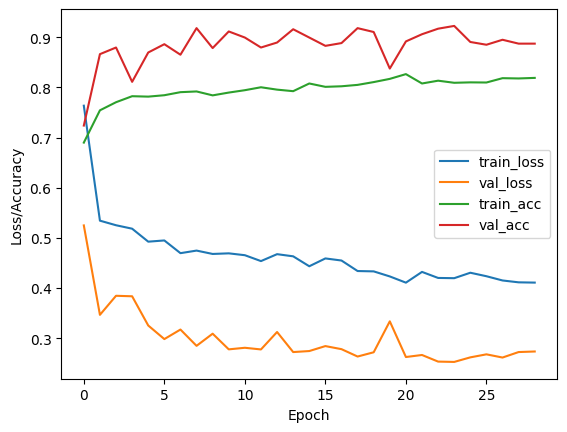

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

In [ ]:
preds = model.predict(testX)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(testY, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(testY, y_pred, target_names=classes))

29/29 [==============================] - 1s 23ms/step
Confusion Matrix:
[[247  32   0]
 [ 21 567   1]
 [  1  15  22]]
Classification Report:
              precision    recall  f1-score   support

  Fair_Light       0.92      0.89      0.90       279
  Medium_Tan       0.92      0.96      0.94       589
   Dark_Deep       0.96      0.58      0.72        38

    accuracy                           0.92       906
   macro avg       0.93      0.81      0.86       906
weighted avg       0.92      0.92      0.92       906



In [ ]:
model.save('/content/drive/MyDrive/Capstone/model.h5')
print("Model saved.")

Model saved.
